##                                  Danny's Dinner Case Study :-

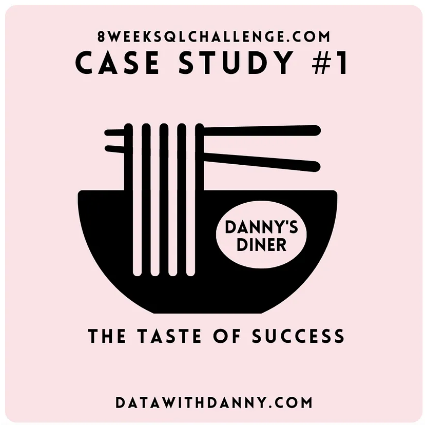

#### Introduction
Danny seriously loves Japanese food so in the beginning of 2021, he decides to embark upon a risky venture and opens up a cute little restaurant that sells his 3 favourite foods: sushi, curry and ramen.

Danny’s Diner is in need of your assistance to help the restaurant stay afloat - the restaurant has captured some very basic data from their few months of operation but have no idea how to use their data to help them run the business.

#### Problem Statement
Danny wants to use the data to answer a few simple questions about his customers, especially about their visiting patterns, how much money they’ve spent and also which menu items are their favourite. Having this deeper connection with his customers will help him deliver a better and more personalised experience for his loyal customers.

He plans on using these insights to help him decide whether he should expand the existing customer loyalty program - additionally he needs help to generate some basic datasets so his team can easily inspect the data without needing to use SQL.

Danny has provided you with a sample of his overall customer data due to privacy issues - but he hopes that these examples are enough for you to write fully functioning SQL queries to help him answer his questions!

Danny has shared with you 3 key datasets for this case study:

- sales
- menu
- members
You can inspect the entity relationship diagram and example data below.

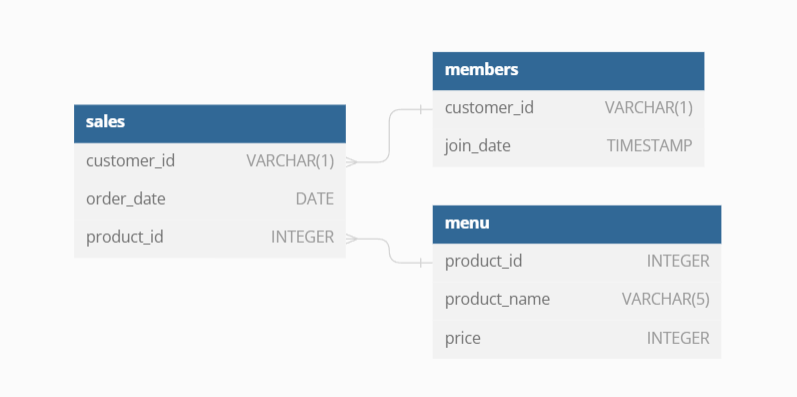

#### 1: Total amount spent by each customer

In [ ]:
SELECT S.customer_id, SUM(M.price)
FROM Menu M
JOIN Sales S ON M.product_id = S.product_id
GROUP BY S.customer_id;

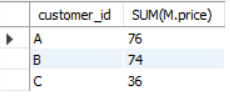

- This query calculates the total amount spent by each customer.
- It joins the "Menu" and "Sales" tables on the "product_id" column.
- Then, it groups the results by "customer_id" and uses the SUM function to calculate the total price spent by customer.

#### 2: How many days each customer visited the restaurant

In [ ]:
SELECT customer_id, COUNT(DISTINCT order_date)
FROM Sales
GROUP BY customer_id;

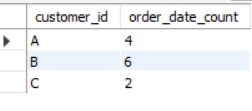

- This query counts the number of distinct days that each customer visited the restaurant.
- It works with the "Sales" table and groups the results by "customer_id."
- The COUNT function is used with DISTINCT to count the unique order dates for each customer.

#### 3: What was the first item from the menu purchased by each customer?

In [ ]:
WITH ranked_dates AS (
    SELECT S.customer_id, M.product_name, S.order_date,
    DENSE_RANK() OVER (PARTITION BY S.customer_id ORDER BY S.order_date) AS ranking
    FROM Sales S
    JOIN Menu M ON S.product_id = M.product_id
)
SELECT customer_id, product_name
FROM ranked_dates
WHERE ranking = 1;

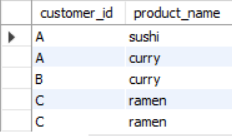

- This query finds the first item purchased by each customer.
- It creates a Common Table Expression (CTE) named "ranked_dates" that ranks purchases based on order date for each customer.
- The final SELECT statement retrieves customer_id and product_name for the rows where the ranking is 1, indicating the first purchase.

#### 4: What is the most purchased item on the menu and how many times was it purchased by all customers?


In [ ]:
SELECT M.product_name, COUNT(S.product_id) AS purchase_count
FROM Sales S
JOIN Menu M ON S.product_id = M.product_id
GROUP BY M.product_name
ORDER BY purchase_count DESC
LIMIT 1;

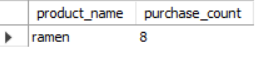

- This query identifies the most purchased item on the menu and how many times it was purchased.
- It joins the "Sales" and "Menu" tables on the "product_id" and groups the results by the "product_name."
- It then counts the number of times each item was purchased and orders the items by purchase count in descending order.
- Finally, it limits the result to the top row, which corresponds to the most purchased item.

#### 5: Which item was the most popular for each customer?

In [ ]:
WITH count_items AS (
    SELECT S.customer_id, M.product_name,
    COUNT(S.product_id) AS item_purchased,
    DENSE_RANK() OVER (PARTITION BY S.customer_id ORDER BY COUNT(S.product_id) DESC) AS ranks
    FROM Sales S
    JOIN Menu M ON S.product_id = M.product_id
    GROUP BY S.customer_id, M.product_name
)
SELECT customer_id, product_name, item_purchased
FROM count_items
WHERE ranks = 1;

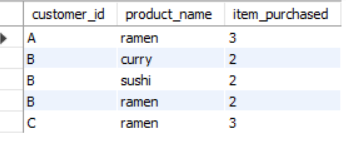


- This query finds the most popular item for each customer, based on the number of purchases.
- It creates a CTE "count_items" that counts the purchases for each customer and product, ranking them by count.
- The final SELECT statement retrieves customer_id, product_name, and item_purchased for the rows where the rank is 1, indicating the most popular item.

#### 6: Which item was purchased first by the customer after they became a member?

In [ ]:
WITH first_product AS (
    SELECT S.customer_id, M.product_name, members.join_date, S.order_date,
    DENSE_RANK() OVER (PARTITION BY S.customer_id ORDER BY S.order_date) AS ranking
    FROM Sales S
    JOIN Menu M ON S.product_id = M.product_id
    JOIN Members members ON S.customer_id = members.customer_id
    WHERE S.order_date >= members.join_date
)
SELECT customer_id, product_name
FROM first_product
WHERE ranking = 1;

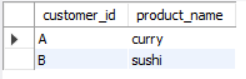

- This query identifies the first item purchased by each customer after they became a member.
- It uses a CTE "first_product" to rank purchases by order date for each customer and filter for purchases made after joining.

#### 7: Which item was purchased just before the customer became a member?

In [ ]:
WITH first_product AS (
    SELECT S.customer_id, M.product_name, members.join_date, S.order_date,
    DENSE_RANK() OVER (PARTITION BY S.customer_id ORDER BY S.order_date) AS ranking
    FROM Sales S
    JOIN Menu M ON S.product_id = M.product_id
    JOIN Members members ON S.customer_id = members.customer_id
    WHERE S.order_date < members.join_date
)
SELECT customer_id, product_name
FROM first_product
WHERE ranking = 1;

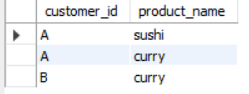

- This query identifies the last item purchased by each customer just before they became a member.
- It uses a CTE "first_product" to rank purchases by order date for each customer and filter for purchases made just before joining.

#### 8: What is the total items and amount spent for each member before they became a member?

In [ ]:
WITH items AS (
    SELECT S.customer_id, S.product_id, M.product_name, members.join_date, S.order_date, M.price
    FROM Sales S
    JOIN Menu M ON S.product_id = M.product_id
    JOIN Members members ON S.customer_id = members.customer_id
)
SELECT customer_id, COUNT(product_id) AS item_count, SUM(price) AS total_spent
FROM items
WHERE order_date < join_date
GROUP BY customer_id
ORDER BY total_spent DESC;

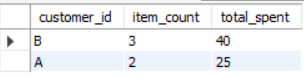

- This query calculates the total number of items and the total amount spent by each member before they became a member.
- It uses a CTE "items" to join the "Sales," "Menu," and "Members" tables, then filters for purchases made before joining.
- Finally, it groups the results by customer_id and orders them by total_spent in descending order.

#### 9: If each $1 spent equates to 10 points and sushi has a 2x points multiplier, how many points would each customer have?

In [ ]:

WITH product_points AS (
    SELECT product_name, price, sales.customer_id,
    CASE
        WHEN product_name = 'sushi' THEN 20 * price
        WHEN product_name <> 'sushi' THEN 10 * price
    END AS points
    FROM Menu
    JOIN Sales ON Sales.product_id = Menu.product_id
)
SELECT customer_id, SUM(points)
FROM product_points
GROUP BY customer_id;

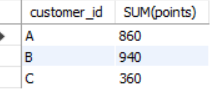

- This query calculates the points earned by each customer based on their purchases.
- It assigns 10 points for every 1 dollar spent, but for 'sushi,' it assigns 20 points per 1 dollar spent due to the 2x points multiplier.
- The query then calculates the total points for each customer.

#### 10: In the first week after a customer joins the program, they earn 2x points on all items, not just sushi. How many points do customer A and B have at the end of January?


In [ ]:
SELECT
    sales.customer_id,
    sales.order_date,
    menu.product_name,
    menu.price,
    CASE
        WHEN members.join_date > sales.order_date THEN 'N'
        WHEN members.join_date <= sales.order_date THEN 'Y'
        ELSE 'N'
    END AS member
FROM sales 
LEFT JOIN menu ON sales.product_id = menu.product_id
LEFT JOIN members ON sales.customer_id = members.customer_id;

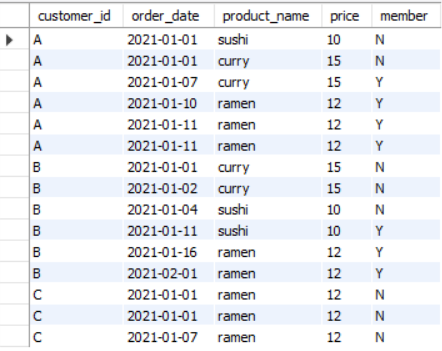


- This query retrieves information about customer purchases and their membership status.
- It selects columns like customer_id, order_date, product_name, price, and a calculated column 'member' based on the join_date.
- If the join_date is after the order_date, the 'member' is 'N' (not a member), otherwise, it's 'Y' (a member).
- The query performs LEFT JOINs on the "sales," "menu," and "members" tables to gather this information.
